## data set 
[Predict Future Sales](https://www.kaggle.com/c/competitive-data-science-predict-future-sales)

* File descriptions
    * sales_train.csv - 훈련 세트. 2013년 1월부터 2015년 10월까지의 일일 과거 데이터입니다.
    * items.csv - 항목/제품에 대한 추가 정보입니다.
    * test.csv -  테스트 세트. 2015년 11월 이러한 상점 및 제품의 매출을 예측해야 합니다.
    * sample_submission.csv - 올바른 형식의 샘플 제출 파일입니다.

* data fields
    * ID  - 테스트 세트 내 (Shop, Item) 튜플을 나타내는 ID
    * shop_id - 상점의 고유 식별자
    * item_id - 제품의 고유 식별자
    * item_category_id - 항목 카테고리의 고유 식별자
    * item_cnt_day - 판매된 제품 수. 이 측정값의 월별 금액을 예측하고 있습니다.
    * item_price - 항목의 현재 가격
    * date  - dd/mm/yyyy 형식의 날짜
    * date_block_num - 편의를 위해 사용되는 연속 월 숫자입니다. 2013년 1월은 0, 2013년 2월은 1,..., 2015년 10월은 33

item_categories.csv 과 shop.csv 는 이름 - 번호 정보만 있어서 사용하지 않음.

In [2]:
kfold_seed = 1234
scoring = 'neg_mean_squared_error'

각 데이터 파일을 불러와 출력한 결과는 다음과 같다. cnt 가 0보다 작은 경우도 있는데  
환불된 상품의 경우 마이너스 값이 들어가는 것으로 추정된다.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

sales_train = pd.read_csv("./data/sales_train.csv")
print(sales_train.head())
print("sales_train data : ", len(sales_train), "\n")

items = pd.read_csv("./data/items.csv")
items = items.drop("item_name", axis = 1)
print(items.head())
print("items data num : ", len(items))
print("category num : ", len(items.groupby("item_category_id")), "\n")

test = pd.read_csv("./data/test.csv")
print(test.head())
print("test data num : ", len(test), "\n")

sales_train2 = pd.merge(sales_train, items, on = "item_id", how = "left") 
print(sales_train2.head())
print("sales - items merge data : ", len(sales_train2), "\n")

shop = pd.read_csv("./data/shops.csv")
print("기타 정보")
print("shop data num : ", len(shop))

         date  date_block_num  shop_id  item_id  item_price  item_cnt_day
0  02.01.2013               0       59    22154      999.00           1.0
1  03.01.2013               0       25     2552      899.00           1.0
2  05.01.2013               0       25     2552      899.00          -1.0
3  06.01.2013               0       25     2554     1709.05           1.0
4  15.01.2013               0       25     2555     1099.00           1.0
sales_train data :  2935849 

   item_id  item_category_id
0        0                40
1        1                76
2        2                40
3        3                40
4        4                40
items data num :  22170
category num :  84 

   ID  shop_id  item_id
0   0        5     5037
1   1        5     5320
2   2        5     5233
3   3        5     5232
4   4        5     5268
test data num :  214200 

         date  date_block_num  shop_id  item_id  item_price  item_cnt_day  \
0  02.01.2013               0       59    22154      999.00 

아래는 다른 자료를 참고하기 전에 먼저 분석해본 내용.  
한번 학습을 시켜 보면서 감을 잡은 후, 해당 프로젝트와 관련된 다른 사람들의 코드나 자료를 참고하여 개선할 것임.  
<br>
## 문제 분석
우선, test 데이터와 submission 형식을 보았을 때  
예측 모델을 만들 경우 <data_block_num> <shop_id> <item_id> 가 입력 데이터의 기준이 되고, 출력데이터는 월별 매출이 되어야 하는 것으로 보인다.  
<br>
이제 위의 입력의 기준이 되는 정보들에 대해 설명하는 데이터를 만들고 학습에 사용할 것이다.  
(**shop_id, item_id 와 같은 정보는 그상태 그대로는 아무런 의미가 없으므로, 이를 수치적으로 의미 있는 정보로 변환해야 한다.**)  
여기서 어떤 정보가 도움이 되는 가에 대해서 다음과 같이 정리해 보았다.  
<br>
가장 먼저 생각해보아야 할 것은 "**이전 date 들에서 해당 item 이 해당 shop 에 대해서 얼마나 많이 팔렸는가 ?**" 이다.    
만약 데이터가 아주 충분해서 모든 shop 이 모든 item 에 대하여 매출 데이터를 가지고 있다면, 그 정보만 가지고 평균을 내거나 회귀함수를 만들어도 어느 정도는 맞겠지만  
**아래에서 보다싶이 shop 마다 모든 아이템에 대한 판매기록이 있는 것이 아니므로**, shop 이나 item category 의 매출 등 다른 정보를 활용해야 한다. 

In [4]:
# shop 마다 판매한 아이템의 종류 중복 없이 출력

sales_train_g_sh =  sales_train.groupby('shop_id')['item_id'].nunique()
print(sales_train_g_sh[:10])

rr = sales_train_g_sh.reset_index()
print("\nmean : ", rr['item_id'].mean())

shop_id
0     3600
1     2523
2     4849
3     5261
4     7309
5     7084
6    11856
7     8246
8     1909
9     1404
Name: item_id, dtype: int64

mean :  7068.733333333334


따라서 shop_id, item_id 에 따른 달별 매출 예측에 영향을 끼칠 수 있는 정보를 다음과 같이 정리하였다.

**1. 해당 shop 에서 해당 item 의 매출 정보**
**2. 모든 shop 에서 해당 item 의 매출 정보**
**3. 해당 shop 의 매출 정보**
**84. 해당 item 의 category 매출 정보**  
<br><br>

item_price 등의 정보도 있지만 일단은 위의 네가지만 고려함.

## Polynomial Regression
여러가지 시도를 해보기 전에 당장 떠오르는 가장 단순한 모델로 학습시켜보면 어느정도 성능이 나오는지 확인해 보기로 하였다.  
<br>
**특정 shop 의 item 에 대하여**,  
<해당 shop에서 아이템의 이전 달 매출> <모든 shop에서 아이템의 이전 달 매출 평균> <해당 shop 의 이전 달 매출 평균> <해당 category 의 이전 달 매출> 이 입력되면  
**해당 month의 매출을 출력** 하는 회귀 모델을 학습시켜 볼 것이다.  
<br>
**<poly regerssion 에서 시도할 수 있는 다른 방법?>**  
이전 달의 매출만 가져오는 대신 그 이전의 매출까지 포괄할 수 있는 값을 사용하거나(ex.지수 가중 평균)  
item 의 이전 매출을 넣는 대신 달 정보(data_block_num) 를 입력값으로 들어가게 해서 달 - 매출 관계가 회귀학습되도록 하는 등  
다양한 방법을 사용할 수 있을 것 같지만 일단은 위와 같이 simple 한 형태의 데이터로 테스트 해 볼 것임.


<br>
아래는 각 데이터를 뽑는 과정이다.  
<br><br>

### 반응 변수 (item_cnt)
기존의 sales_trian 은 item 매출이 발생할때마다 기록된 데이터이므로, 이를 data_block_num / shop_id / item_id 로 group 지어 item_cnt 의 sum을 출력함.

In [5]:
sales = sales_train.drop(["date", "item_price"], axis = 1)
print(sales.head())
print("selected data : ", len(sales), "\n")

montly_sales = sales.groupby(["date_block_num", "shop_id", "item_id"]).sum()
print(montly_sales.head())
print("group by data_block_num / shop_id / item_id : ", len(montly_sales), "\n")

print("(sales_train -> montly_sales) data num rate : ", round(len(montly_sales)/len(sales_train)*100, 2), "%")

   date_block_num  shop_id  item_id  item_cnt_day
0               0       59    22154           1.0
1               0       25     2552           1.0
2               0       25     2552          -1.0
3               0       25     2554           1.0
4               0       25     2555           1.0
selected data :  2935849 

                                item_cnt_day
date_block_num shop_id item_id              
0              0       32                6.0
                       33                3.0
                       35                1.0
                       43                1.0
                       51                2.0
group by data_block_num / shop_id / item_id :  1609124 

(sales_train -> montly_sales) data num rate :  54.81 %


groupby 로 집계한 내용을 다시 dataframe 형식으로 변환.  
item_cnt_day 를 item_cnt_month 로 변경.

In [6]:
montly_sales = montly_sales.reset_index()
montly_sales.rename(columns = {"item_cnt_day": "item_cnt_month"}, inplace = True)
print(montly_sales)

         date_block_num  shop_id  item_id  item_cnt_month
0                     0        0       32             6.0
1                     0        0       33             3.0
2                     0        0       35             1.0
3                     0        0       43             1.0
4                     0        0       51             2.0
...                 ...      ...      ...             ...
1609119              33       59    22087             6.0
1609120              33       59    22088             2.0
1609121              33       59    22091             1.0
1609122              33       59    22100             1.0
1609123              33       59    22102             1.0

[1609124 rows x 4 columns]


이전 달 매출을 사용하여 예측한다는 설정이므로 첫번 째 달(date_block_num = 0) 인 데이터는 제외 

In [7]:
montly_sales_except0 = montly_sales[montly_sales.date_block_num != 0]
print(montly_sales_except0)

         date_block_num  shop_id  item_id  item_cnt_month
63224                 1        0       30            31.0
63225                 1        0       31            11.0
63226                 1        0       32            10.0
63227                 1        0       33             3.0
63228                 1        0       35            14.0
...                 ...      ...      ...             ...
1609119              33       59    22087             6.0
1609120              33       59    22088             2.0
1609121              33       59    22091             1.0
1609122              33       59    22100             1.0
1609123              33       59    22102             1.0

[1545900 rows x 4 columns]


### 설명 변수 1 (해당 shop에서 아이템의 이전 달 매출)
montly_sales 데이터 그대로 date_block_num 에 1을 더해서 출력

In [8]:
shop_item_cnt = montly_sales.copy()

date_block_num = shop_item_cnt["date_block_num"]
add_1 = pd.Series([1]*len(montly_sales))

date_block_num = date_block_num.add(add_1, fill_value=0)

shop_item_cnt['date_block_num'] = date_block_num

shop_item_cnt.rename(columns = {"item_cnt_month": "shop_item_cnt"}, inplace = True)
print(shop_item_cnt)

         date_block_num  shop_id  item_id  shop_item_cnt
0                     1        0       32            6.0
1                     1        0       33            3.0
2                     1        0       35            1.0
3                     1        0       43            1.0
4                     1        0       51            2.0
...                 ...      ...      ...            ...
1609119              34       59    22087            6.0
1609120              34       59    22088            2.0
1609121              34       59    22091            1.0
1609122              34       59    22100            1.0
1609123              34       59    22102            1.0

[1609124 rows x 4 columns]


### 설명 변수 2 (모든 shop에서 아이템의 이전 달 매출)

In [9]:
item_cnt = shop_item_cnt.copy()
item_cnt = item_cnt.drop("shop_id", axis = 1)

item_cnt = item_cnt.groupby(["date_block_num", "item_id"]).sum()
item_cnt = item_cnt.reset_index()

item_cnt.rename(columns = {"shop_item_cnt": "item_cnt"}, inplace = True)
print(item_cnt)

        date_block_num  item_id  item_cnt
0                    1       19       1.0
1                    1       27       7.0
2                    1       28       8.0
3                    1       29       4.0
4                    1       32     299.0
...                ...      ...       ...
233907              34    22162      10.0
233908              34    22163      26.0
233909              34    22164      15.0
233910              34    22166      11.0
233911              34    22167      37.0

[233912 rows x 3 columns]


### 설명 변수 3 (해당 shop 의 이전 달 매출)
shop cnt 는 최대 1980 개(33 * 60) 나올거라고 생각했는데 실제로는 1585 개가 출력됨.  
rows 를 전부 출력해보았고, 모든 shop 이 33개의 month 에서 아이템 판매 기록을 가지진 않은 것을 확인하였음.

In [10]:
shop_cnt = shop_item_cnt.copy()
shop_cnt = shop_cnt.drop("item_id", axis = 1)

shop_cnt = shop_cnt.groupby(["date_block_num", "shop_id"]).sum()
shop_cnt = shop_cnt.reset_index()

shop_cnt.rename(columns = {"shop_item_cnt": "shop_cnt"}, inplace = True)
print(shop_cnt)

#with pd.option_context("display.max_rows", None):
#    print(shop_cnt)


      date_block_num  shop_id  shop_cnt
0                  1        0    5578.0
1                  1        1    2947.0
2                  1        2    1146.0
3                  1        3     767.0
4                  1        4    2114.0
...              ...      ...       ...
1581              34       55    1972.0
1582              34       56    1263.0
1583              34       57    2316.0
1584              34       58    1446.0
1585              34       59     790.0

[1586 rows x 3 columns]


### 설명 변수 4 (해당 category 의 이전 달 매출)

In [11]:
category_cnt = sales_train2.copy()
category_cnt = category_cnt.drop(["shop_id", "item_id", "item_price"], axis = 1)

category_cnt = category_cnt.groupby(["date_block_num", "item_category_id"]).sum()
category_cnt = category_cnt.reset_index()

category_cnt.rename(columns = {"item_cnt_day": "category_cnt"}, inplace = True)
print(category_cnt)

      date_block_num  item_category_id  category_cnt
0                  0                 0           1.0
1                  0                 1           1.0
2                  0                 2        1390.0
3                  0                 3         440.0
4                  0                 4         251.0
...              ...               ...           ...
2072              33                76         184.0
2073              33                77          64.0
2074              33                78          64.0
2075              33                79         521.0
2076              33                83         348.0

[2077 rows x 3 columns]


### train data set
montly_sales_except 에 설명 변수 4가지의 dataframe 들을 차례차례 merge 한다.  

In [12]:
train_X = montly_sales_except0.loc[:, montly_sales.columns != "item_cnt_month"]
train_y = montly_sales_except0["item_cnt_month"]

In [13]:
train_X = pd.merge(train_X, shop_item_cnt, on = ["date_block_num", "shop_id", "item_id"], how = "left") 
train_X["shop_item_cnt"] = train_X["shop_item_cnt"].fillna(0)

train_X = pd.merge(train_X, item_cnt, on = ["date_block_num", "item_id"], how = "left")
train_X["item_cnt"] = train_X["item_cnt"].fillna(0)

train_X = pd.merge(train_X, shop_cnt, on = ["date_block_num", "shop_id"], how = "left")
train_X["shop_cnt"] = train_X["shop_cnt"].fillna(0)

# categoty_cnt 는 merge 하기 전 train_X 에 category 정보 자체가 먼저 들어가야 한다. 
train_X = pd.merge(train_X, items, on = "item_id", how = "left") 
train_X = pd.merge(train_X, category_cnt, on = ["date_block_num", "item_category_id"], how = "left")
train_X["category_cnt"] = train_X["category_cnt"].fillna(0)

print(train_X)

         date_block_num  shop_id  item_id  shop_item_cnt  item_cnt  shop_cnt  \
0                     1        0       30            0.0       0.0    5578.0   
1                     1        0       31            0.0       0.0    5578.0   
2                     1        0       32            6.0     299.0    5578.0   
3                     1        0       33            3.0      61.0    5578.0   
4                     1        0       35            1.0      78.0    5578.0   
...                 ...      ...      ...            ...       ...       ...   
1545895              33       59    22087            3.0      60.0     914.0   
1545896              33       59    22088            1.0     130.0     914.0   
1545897              33       59    22091            3.0      43.0     914.0   
1545898              33       59    22100            1.0      94.0     914.0   
1545899              33       59    22102            0.0     144.0     914.0   

         item_category_id  category_cnt

train_X 에서 id 값들을 제거하고, 설명변수 값들만을 남긴다.  

In [14]:
train_X = train_X.drop(["date_block_num", "shop_id", "item_id", "item_category_id"], axis = 1)
train_y.index = list(range(0, 1545900))

print("train_X : ")
print(train_X)
print("\ntrain_y : ")
print(train_y)

train_X : 
         shop_item_cnt  item_cnt  shop_cnt  category_cnt
0                  0.0       0.0    5578.0       31649.0
1                  0.0       0.0    5578.0        6307.0
2                  6.0     299.0    5578.0       31649.0
3                  3.0      61.0    5578.0        6307.0
4                  1.0      78.0    5578.0       31649.0
...                ...       ...       ...           ...
1545895            3.0      60.0     914.0         348.0
1545896            1.0     130.0     914.0         348.0
1545897            3.0      43.0     914.0         348.0
1545898            1.0      94.0     914.0         934.0
1545899            0.0     144.0     914.0         934.0

[1545900 rows x 4 columns]

train_y : 
0          31.0
1          11.0
2          10.0
3           3.0
4          14.0
           ... 
1545895     6.0
1545896     2.0
1545897     1.0
1545898     1.0
1545899     1.0
Name: item_cnt_month, Length: 1545900, dtype: float64


numpy 자료형으로 변환하고 **normarlizing**.

In [15]:
from sklearn import preprocessing

train_X_np = train_X.to_numpy()
train_y_np = train_y.to_numpy()

std_scaler = preprocessing.StandardScaler().fit(train_X)
train_X_np = std_scaler.transform(train_X)

print("train_X numpy [:5] : ")
print(train_X_np[:5])
print(train_X_np.shape)

print("\ntrain_y numpy [:5] : ")
print(train_y_np[:5])
print(train_y_np.shape)

train_X numpy [:5] : 
[[-0.18587112 -0.22841774  0.85575128  2.69399191]
 [-0.18587112 -0.22841774  0.85575128 -0.33233613]
 [ 0.55067652  1.03142819  0.85575128  2.69399191]
 [ 0.1824027   0.02860768  0.85575128 -0.33233613]
 [-0.06311318  0.10023772  0.85575128  2.69399191]]
(1545900, 4)

train_y numpy [:5] : 
[31. 11. 10.  3. 14.]
(1545900,)


3차항 회귀를 하기 위해 PolynomialFeatures 사용. 
(sklearn 에서는 고차항 회귀가 모델이 아니라 데이터를 transform 함으로서 구현된다. 모델은 그대로 LinearRegression 사용.)  
원래 한꺼번에 변환하려고 했으나 메모리 부족 오류(**Unable to allocate 441**) 가 발생해서 10개 묶음으로 나눠서 처리함.

In [16]:
from sklearn import model_selection
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

poly = PolynomialFeatures(degree = 3, include_bias = False)

In [17]:
def make_poly_data(train_X_np, poly):

    temp_list = []

    split_num = 10
    split_term = len(train_X_np)//split_num

    for i in range(split_num):
        temp_list.append(poly.fit_transform(train_X_np[i*split_term:(i+1)*split_term]))


    if len(train_X_np)%split_num != 0:
        temp_list.append(poly.fit_transform(train_X_np[split_num*split_term:]))
    train_X_np_poly = np.concatenate(temp_list, axis = 0)

    print("ori data shape : ", train_X_np.shape)
    print("poly data shape : ", train_X_np_poly.shape)
    print("\n poly data sample")
    print(train_X_np_poly[0])
    
    return train_X_np_poly

train_X_np_poly = make_poly_data(train_X_np, poly)

ori data shape :  (1545900, 4)
poly data shape :  (1545900, 34)

 poly data sample
[-1.85871117e-01 -2.28417738e-01  8.55751281e-01  2.69399191e+00
  3.45480721e-02  4.24562600e-02 -1.59059446e-01 -5.00735285e-01
  5.21746628e-02 -1.95468771e-01 -6.15355536e-01  7.32310255e-01
  2.30538702e+00  7.25759239e+00 -6.42148875e-03 -7.89139247e-03
  2.95645570e-02  9.30722266e-02 -9.69776285e-03  3.63319989e-02
  1.14376821e-01 -1.36115325e-01 -4.28504861e-01 -1.34897680e+00
 -1.19176184e-02  4.46485345e-02  1.40558119e-01 -1.67272652e-01
 -5.26591288e-01 -1.65776283e+00  6.26675439e-01  1.97283790e+00
  6.21069398e+00  1.95518951e+01]


위에서 poly 가 적용된 34개의 feature 는  
원래의 데이터 feature + 원래의 데이터에 차수가 적용된 값(다른 feature 와 iteraction 한 값까지 포함)  
으로 구성된다.  
<br>
linearRegression 자체에도 편향의 역할을 하는 intercept_ 가 포함되어 있기 때문에 입력데이터에는 편향값을 포함시킬 필요가 없다고 생각하여 bias 는 추가하지 않았다.

In [23]:
def poly_regression_train(train_X, train_y, model):
    kfold = model_selection.KFold(n_splits = 10, random_state = kfold_seed, shuffle = True)

    cv_results_1 = model_selection.cross_val_score(model, train_X, train_y, cv = kfold, scoring = scoring, n_jobs = -1)
    msg = "%s: %f (%f)" % ("polynomial regression MSE", cv_results_1.mean(), cv_results_1.std())
    print(msg)

    cv_results_2 = model_selection.cross_val_score(model, train_X, train_y, cv = kfold, scoring = "r2", n_jobs = -1)
    msg = "%s: %f (%f)" % ("polynomial regression r2", cv_results_2.mean(), cv_results_2.std())
    print(msg)
    
    return cv_results_1.mean(), cv_results_2.mean()

In [ ]:
model = LinearRegression()
poly_regression_train(train_X_np_poly, train_y_np, model)

원래는 feature 를 전부 사용하려고 했으나, 34개의 feature 에 데이터가 백만개가 넘다보니 학습이 너무 오래걸렸다.  
따라서 4 개의 feature 를 사용한 linear regression  
4개의 feature 를 사용한 2차항 poly regression   
3개의 feature 를 사용한 3차항 poly regression 을 각각 시도하였다.  
<br>

### 4개의 feature 를 사용한 linear regression

In [24]:
model = LinearRegression()
poly_regression_train(train_X_np, train_y_np, model)

polynomial regression MSE: -44.048909 (11.096444)
polynomial regression r2: 0.428368 (0.098420)


(-44.04890873318833, 0.4283675136286716)

### 4개의 feature 를 사용한 2차항 poly regression

In [21]:
# data merge
train_X = montly_sales_except0.loc[:, montly_sales.columns != "item_cnt_month"]
train_y = montly_sales_except0["item_cnt_month"]

train_X = pd.merge(train_X, shop_item_cnt, on = ["date_block_num", "shop_id", "item_id"], how = "left") 
train_X["shop_item_cnt"] = train_X["shop_item_cnt"].fillna(0)

train_X = pd.merge(train_X, item_cnt, on = ["date_block_num", "item_id"], how = "left")
train_X["item_cnt"] = train_X["item_cnt"].fillna(0)

train_X = pd.merge(train_X, shop_cnt, on = ["date_block_num", "shop_id"], how = "left")
train_X["shop_cnt"] = train_X["shop_cnt"].fillna(0)

# 설명변수 제외하고 drop
train_X = train_X.drop(["date_block_num", "shop_id", "item_id"], axis = 1)
train_y.index = list(range(0, 1545900))

# numpy 자료형으로 변환하고 standardization
train_X_np = train_X.to_numpy()
train_y_np = train_y.to_numpy()

std_scaler = preprocessing.StandardScaler().fit(train_X)
train_X_np = std_scaler.transform(train_X)

print("train_X numpy [:5] : ")
print(train_X_np[:5])
print(train_X_np.shape)

print("\ntrain_y numpy [:5] : ")
print(train_y_np[:5])
print(train_y_np.shape, "\n\n")

# polynomial data 로 변환
poly = PolynomialFeatures(degree = 2, include_bias = False)
train_X_np_poly = make_poly_data(train_X_np, poly)

train_X numpy [:5] : 
[[-0.18587112 -0.22841774  0.85575128]
 [-0.18587112 -0.22841774  0.85575128]
 [ 0.55067652  1.03142819  0.85575128]
 [ 0.1824027   0.02860768  0.85575128]
 [-0.06311318  0.10023772  0.85575128]]
(1545900, 3)

train_y numpy [:5] : 
[31. 11. 10.  3. 14.]
(1545900,) 


ori data shape :  (1545900, 3)
poly data shape :  (1545900, 9)

 poly data sample
[-0.18587112 -0.22841774  0.85575128  0.03454807  0.04245626 -0.15905945
  0.05217466 -0.19546877  0.73231025]


In [25]:
model = LinearRegression()
poly_regression_train(train_X_np_poly, train_y_np, model)

polynomial regression MSE: -43.099399 (11.667345)
polynomial regression r2: 0.442412 (0.101046)


### 3개의 feature 를 사용한 3차항 poly regression

In [25]:
# data merge
train_X = montly_sales_except0.loc[:, montly_sales.columns != "item_cnt_month"]
train_y = montly_sales_except0["item_cnt_month"]

train_X = pd.merge(train_X, shop_item_cnt, on = ["date_block_num", "shop_id", "item_id"], how = "left") 
train_X["shop_item_cnt"] = train_X["shop_item_cnt"].fillna(0)

train_X = pd.merge(train_X, item_cnt, on = ["date_block_num", "item_id"], how = "left")
train_X["item_cnt"] = train_X["item_cnt"].fillna(0)

train_X = pd.merge(train_X, shop_cnt, on = ["date_block_num", "shop_id"], how = "left")
train_X["shop_cnt"] = train_X["shop_cnt"].fillna(0)

# 설명변수 제외하고 drop
train_X = train_X.drop(["date_block_num", "shop_id", "item_id"], axis = 1)
train_y.index = list(range(0, 1545900))

# numpy 자료형으로 변환하고 standardization
train_X_np = train_X.to_numpy()
train_y_np = train_y.to_numpy()

std_scaler = preprocessing.StandardScaler().fit(train_X)
train_X_np = std_scaler.transform(train_X)

print("train_X numpy [:5] : ")
print(train_X_np[:5])
print(train_X_np.shape)

print("\ntrain_y numpy [:5] : ")
print(train_y_np[:5])
print(train_y_np.shape, "\n\n")

# polynomial data 로 변환
poly = PolynomialFeatures(degree = 3, include_bias = False)
train_X_np_poly = make_poly_data(train_X_np, poly)

train_X numpy [:5] : 
[[-0.18587112 -0.22841774  0.85575128]
 [-0.18587112 -0.22841774  0.85575128]
 [ 0.55067652  1.03142819  0.85575128]
 [ 0.1824027   0.02860768  0.85575128]
 [-0.06311318  0.10023772  0.85575128]]
(1545900, 3)

train_y numpy [:5] : 
[31. 11. 10.  3. 14.]
(1545900,) 


ori data shape :  (1545900, 3)
poly data shape :  (1545900, 19)

 poly data sample
[-0.18587112 -0.22841774  0.85575128  0.03454807  0.04245626 -0.15905945
  0.05217466 -0.19546877  0.73231025 -0.00642149 -0.00789139  0.02956456
 -0.00969776  0.036332   -0.13611533 -0.01191762  0.04464853 -0.16727265
  0.62667544]


In [26]:
poly3_model = LinearRegression()
MSE, r2 = poly_regression_train(train_X_np_poly, train_y_np, poly3_model)

polynomial regression MSE: -41.251003 (11.033622)
polynomial regression r2: 0.463917 (0.111436)


3 가지의 설정으로 regression 을 돌려보았다. polynomial 의 차수가 올라갈수록 score 가 좋아지기는 했지만,  
가장 결과가 잘 나온 3차항 회귀에서도 MSE 는 41, r2 는 0.46 정도가 나왔는데 **r2 스코어가 0.7 이상은 나와야 쓸만한 모델인 것을  
감안하면** 결과가 잘 나오지는 않은것을 알 수 있었다.  
<br>
차수를 더 늘리면 오차가 좀더 줄어들 수도 있다고 생각했지만, 그렇다면 차라리 딥러닝 라이브러리로 gpu 를 사용해서 계산하는 나을 것 같아서 우선 train data 의 label 값 분포를 살펴보고 다른 모델을 시도해보기로 하였다.

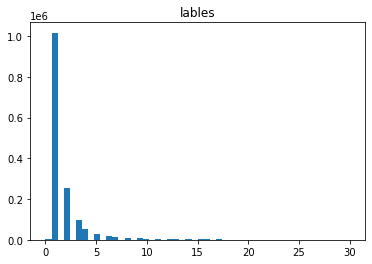

mean :  2.274873536451258
min :  -22.0
max :  2253.0
square root of MSE :  nan


<ipython-input-27-f37ac2048bf5>:9: RuntimeWarning: invalid value encountered in double_scalars
  print("square root of MSE : ", MSE**(1/2))


In [27]:
hist = plt.hist(train_y_np, range=(0, 30), bins = 50)
plt.title("lables")
plt.show()

print("mean : ", train_y_np.mean())
print("min : ", train_y_np.min())
print("max : ", train_y_np.max())

print("square root of MSE : ", MSE**(1/2))

label 값의 분포를 살펴보면 대부분이 1 ~ 5 사이에 분포하는 것에 비해 최댓값(2253) 이 굉장히 큰 것을 알 수 있었다.  
상점들마다 특별히 잘 팔리는 상품이 있고, 대부분의 상품들은 5개 이하로 팔리는 것으로 보인다.  
<br>
따라서 회귀를 사용할 경우 그래프가 1 ~ 5 의 라벨값을 가지는 아이템 기준으로 맞춰지고 cnt 가 큰 아이템에서 오차가 크게 발생하여 MSE score 가 좋게 나오지 못한 것이라는 가정을 하였다.  
<br>
실제로 error 가 가장 큰 item 20 개를 뽑았을 때 전부 label 값(montly_cnt) 가 큰 아이템들이었다. 

In [46]:
from sklearn.metrics import mean_squared_error

poly3_model.fit(train_X_np_poly, train_y_np)
pred_y = poly3_model.predict(train_X_np_poly)

train_y_np_reshape = train_y_np.copy().reshape(1, -1) 
pred_y_reshape = pred_y.reshape(1, -1)

MSE_multioutput = mean_squared_error(train_y_np_reshape, pred_y_reshape, multioutput = "raw_values")
MSE_sort_top20 = np.argsort(MSE_multioutput)[::-1][:20]

train_y_mse_sort = train_y_np[MSE_sort_top20]
pred_y_mse_sort = pred_y[MSE_sort_top20]

print("Top 20 items with big errors -> ")
print("train_y : pred_y_mse_sort")
for i in range(20):
    print("{0:<9}{1}".format(train_y_mse_sort[i], pred_y_mse_sort[i]))

Top 20 items with big errors -> 
train_y : pred_y_mse_sort
2253.0   151.62994547501222
1644.0   9.614543795500492
1644.0   9.746952676541715
1242.0   1.5003293141183627
1127.0   23.592326275251548
1074.0   1.5306972720445418
1117.0   108.68584021392113
903.0    1.6067730217977232
904.0    4.720201912266497
813.0    1.5619521451735652
1000.0   297.50116129347555
766.0    81.40713725664912
680.0    18.61384428912676
716.0    85.5192102126681
751.0    122.06586863667661
597.0    14.140284275457805
597.0    14.30099761233046
742.0    179.84830299259824
563.0    1.492184042684534
550.0    1.4864043425981817
